# Explore trade-weighted dollar indices on the FRED

Compare other USD currency pairs with trade-weighted indices

In [1]:
library(tidyverse)
library(ggthemes)
library(odbc)
library(plutoR)
library(quantmod)
library(PerformanceAnalytics)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")
source("goofy/misc.common.R")

fred<-Fred()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend

Registering fonts with R

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package

In [2]:
cutoff <- Sys.Date() - 15
fred$Meta() %>% inner_join(fred$TimeSeries(), by = 'SERIES_ID') %>%
    filter(NAME %like% '%dollar%' & FREQUENCY == 'D') %>%
    group_by(SERIES_ID, TICKER, NAME) %>%
    summarize(MIN_TS = min(TIME_STAMP), MAX_TS = max(TIME_STAMP)) %>%
    filter(MAX_TS >= cutoff) %>%
    select(SERIES_ID, TICKER, NAME, MIN_TS, MAX_TS) %>%
    print(n=Inf)

Warning message:
“Missing values are always removed in SQL.
Use `MIN(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”Warning message:
“Missing values are always removed in SQL.
Use `MAX(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”

# Source:   lazy query [?? x 5]
# Database: Microsoft SQL Server 13.00.4224[ro1@NORWAY/StockVizUs]
# Groups:   SERIES_ID, TICKER
    SERIES_ID TICKER     NAME                              MIN_TS     MAX_TS    
        <int> <chr>      <chr>                             <date>     <date>    
 1    -2.15e9 DTWEXB     Trade Weighted U.S. Dollar Index… 1995-01-04 2019-06-21
 2    -2.15e9 DTWEXM     Trade Weighted U.S. Dollar Index… 1973-01-02 2019-06-21
 3    -2.15e9 DTWEXO     Trade Weighted U.S. Dollar Index… 1995-01-04 2019-06-21
 4    -2.15e9 GOLDAMGBD… Gold Fixing Price 10:30 A.M. (Lo… 1968-04-01 2019-06-27
 5    -2.15e9 GOLDPMGBD… Gold Fixing Price 3:00 P.M. (Lon… 1968-04-01 2019-06-27
 6    -2.15e9 USD12MD15… 12-Month London Interbank Offere… 1986-01-02 2019-06-20
 7    -2.15e9 USD1MTD15… 1-Month London Interbank Offered… 1986-01-02 2019-06-20
 8    -2.15e9 USD1WKD15… 1-Week London Interbank Offered … 1997-12-01 2019-06-20
 9    -2.15e9 USD2MTD15… 2-Month London Interbank Offered… 19

### compare USDINR and the EM trade-weighted index

In [3]:
emId <- -2146970542 #DTWEXEMEGS
inrId <- -2147478748 #DEXINUS, from the example: http://pluto.studio/user/shyams80/notebooks/docs-R/Fred.ipynb

startDt <- as.Date("2006-01-02")
endDt <- as.Date("2019-06-20")

#get EM index data
emDf <- data.frame(fred$TimeSeries() %>% filter(SERIES_ID == emId & TIME_STAMP >= startDt & TIME_STAMP <= endDt) %>% 
    select(TIME_STAMP, VAL))
emDf$TIME_STAMP <- as.Date(emDf$TIME_STAMP)

fredDetailsEm <- data.frame(fred$Meta() %>% filter(SERIES_ID == emId))


#get USDINR data
usdInrDf <- data.frame(fred$TimeSeries() %>% filter(SERIES_ID == inrId & TIME_STAMP >= startDt & TIME_STAMP <= endDt) %>% 
    select(TIME_STAMP, VAL))
usdInrDf$TIME_STAMP <- as.Date(usdInrDf$TIME_STAMP)

fredDetailsUsdInr <- data.frame(fred$Meta() %>% filter(SERIES_ID == inrId))

#convert to xts
emXts <- xts(emDf$VAL, emDf$TIME_STAMP)
usdInrXts <- xts(usdInrDf$VAL, usdInrDf$TIME_STAMP)

In [4]:
#end-of months don't match, so force them to a common date
monthlies <- merge(Common.NormalizeMonthlyDates(monthlyReturn(emXts)), 
                   Common.NormalizeMonthlyDates(monthlyReturn(usdInrXts)))
names(monthlies) <-c('EM', 'USDINR')

print(head(monthlies))

                     EM       USDINR
2006-01-20 -0.016063000 -0.021371327
2006-02-20 -0.001003113  0.005686988
2006-03-20  0.010404395  0.006107216
2006-04-20 -0.003724412  0.008543165
2006-05-20  0.012682445  0.030316540
2006-06-20 -0.001912124 -0.007572479


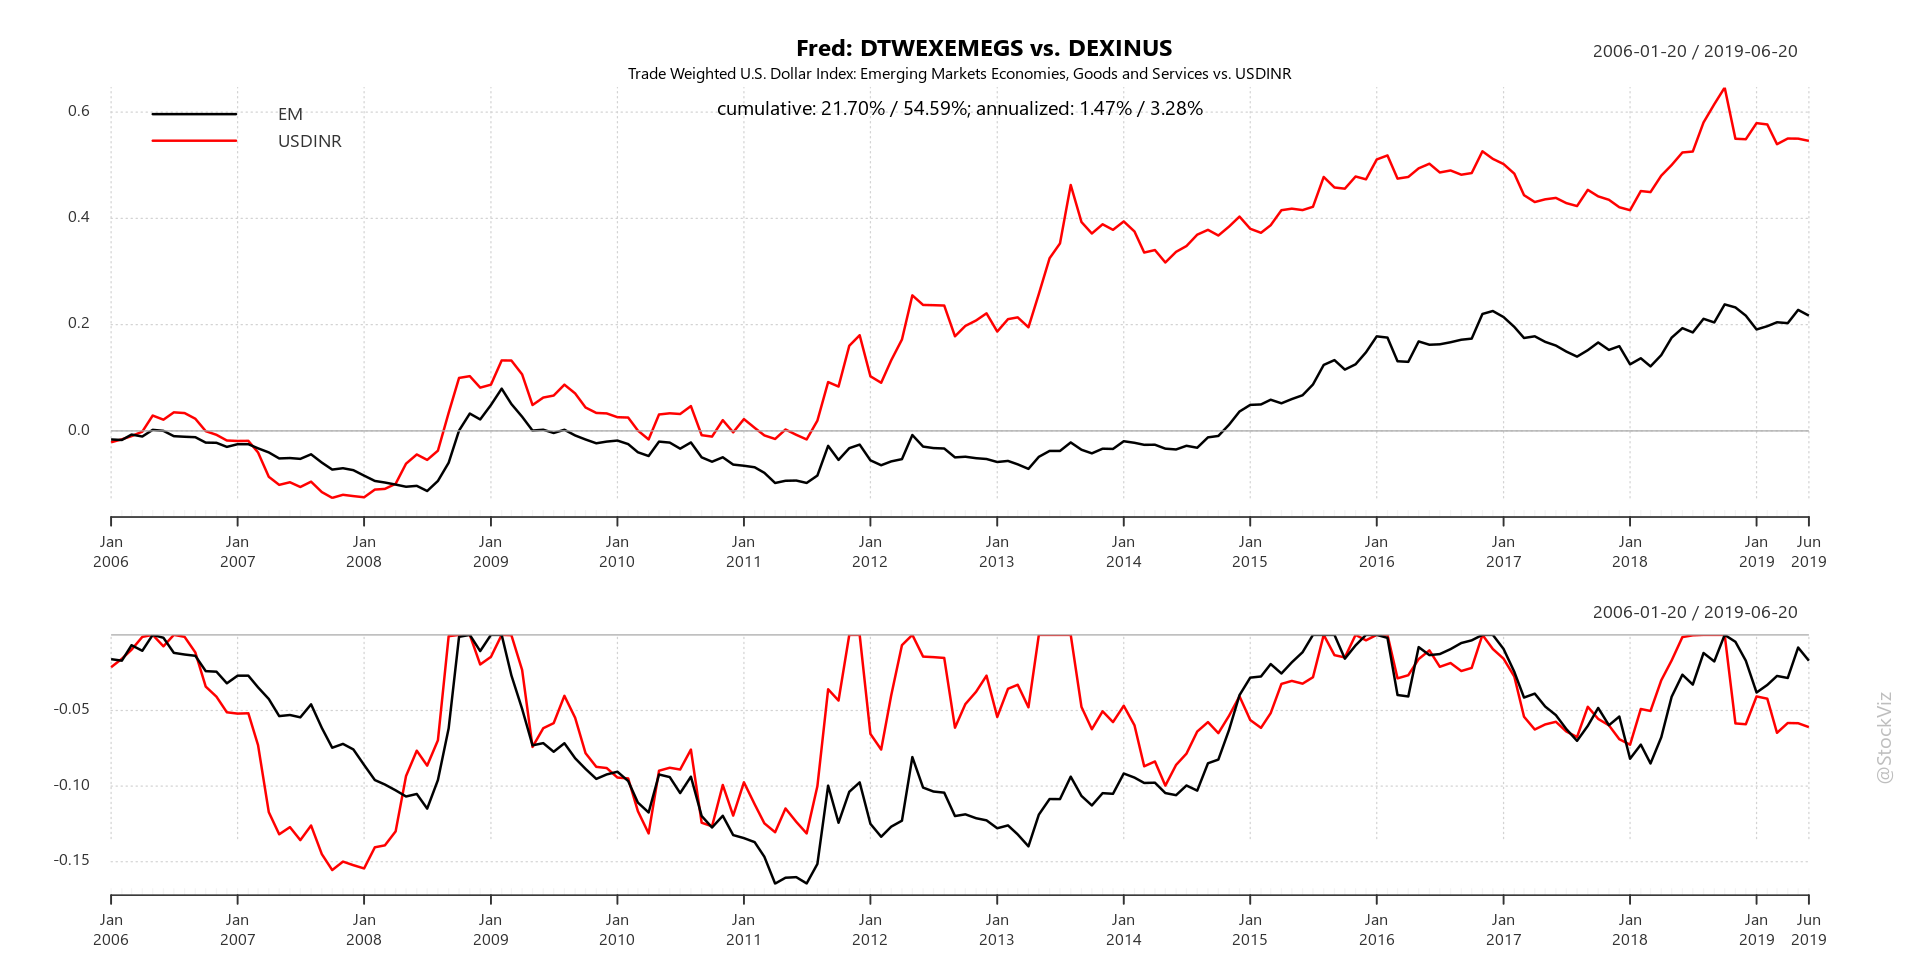

In [5]:
Common.PlotCumReturns(monthlies, "Fred: DTWEXEMEGS vs. DEXINUS", "Trade Weighted U.S. Dollar Index: Emerging Markets Economies, Goods and Services vs. USDINR")

### add the thai bhat to the comparison

In [6]:
fred$Meta() %>% inner_join(fred$TimeSeries(), by = 'SERIES_ID') %>%
    filter(NAME %like% '%exchange%' & NAME %like% '%thai%' & FREQUENCY == 'D') %>%
    group_by(SERIES_ID, TICKER, NAME) %>%
    summarize(MIN_TS = min(TIME_STAMP), MAX_TS = max(TIME_STAMP)) %>%
    filter(MAX_TS >= cutoff) %>%
    select(SERIES_ID, TICKER, NAME, MIN_TS, MAX_TS) %>%
    print(n=Inf)

# Source:   lazy query [?? x 5]
# Database: Microsoft SQL Server 13.00.4224[ro1@NORWAY/StockVizUs]
# Groups:   SERIES_ID, TICKER
    SERIES_ID TICKER  NAME                                 MIN_TS     MAX_TS    
        <int> <chr>   <chr>                                <date>     <date>    
1 -2147478736 DEXTHUS Thailand / U.S. Foreign Exchange Ra… 1981-01-02 2019-06-21


In [7]:
c1Id <- -2147478736 #DEXTHUS 

#get 2nd currency data
c1Df <- data.frame(fred$TimeSeries() %>% filter(SERIES_ID == c1Id & TIME_STAMP >= startDt & TIME_STAMP <= endDt) %>% 
    select(TIME_STAMP, VAL))
c1Df$TIME_STAMP <- as.Date(c1Df$TIME_STAMP)

fredDetailsC1 <- data.frame(fred$Meta() %>% filter(SERIES_ID == c1Id))

#convert to xts
c1Xts <- xts(c1Df$VAL, c1Df$TIME_STAMP)

monthlies <- merge(monthlies, Common.NormalizeMonthlyDates(monthlyReturn(c1Xts)))
names(monthlies) <-c('EM', 'USDINR', 'USDTHB')

print(head(monthlies))

                     EM       USDINR       USDTHB
2006-01-20 -0.016063000 -0.021371327 -0.045878312
2006-02-20 -0.001003113  0.005686988  0.005142710
2006-03-20  0.010404395  0.006107216 -0.006395498
2006-04-20 -0.003724412  0.008543165 -0.034243048
2006-05-20  0.012682445  0.030316540  0.014929352
2006-06-20 -0.001912124 -0.007572479  0.001838718


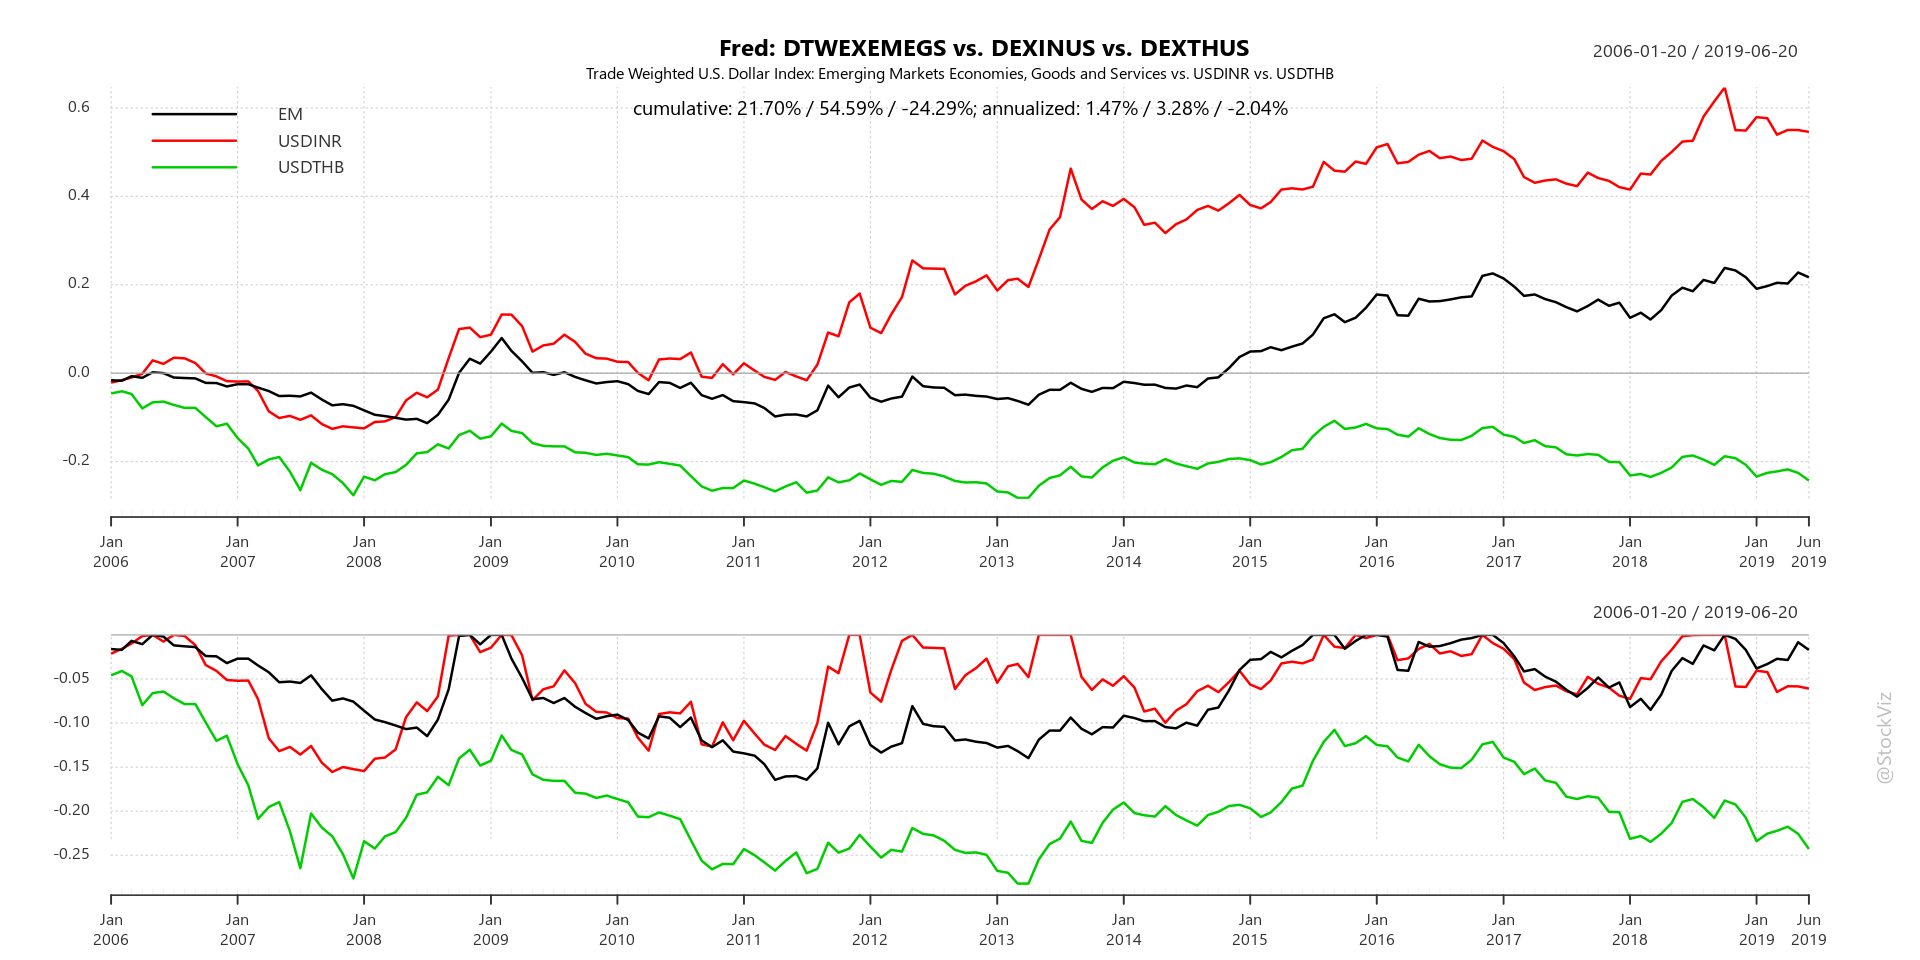

In [8]:
Common.PlotCumReturns(monthlies, "Fred: DTWEXEMEGS vs. DEXINUS vs. DEXTHUS", "Trade Weighted U.S. Dollar Index: Emerging Markets Economies, Goods and Services vs. USDINR vs. USDTHB")

#### If the strength of its currency is a indication of a country's economic health, then what does this say about India's?

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)